# 2. Clip crop cover area

#### Data sources:
- USA Land Use Land Cover (LULC) data with crop classification: CroplandCROS (https://croplandcros.scinet.usda.gov/, https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php)
    - local data copy: `2022_30m_cdls.tif`
    - citation: USDA National Agricultural Statistics Service Cropland Data Layer. {YEAR}. Published crop-specific data layer [Online]. Available at https://nassgeodata.gmu.edu/CropScape/ (accessed {DATE}; verified {DATE}). USDA-NASS, Washington, DC.
    
    
#### Procedure:

- Use the bounding box of the area (not cliped by urban areas) to clip the crop data raster layer
- Save cliped raster layer for further processingp  

In [1]:
# import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define input raster file
raster_file = '../external_data/CroplandCROS/2022_30m_cdls/2022_30m_cdls.tif'

# define output clipped file
out_clip = '../process_data/2022_30m_cdls_clip.tif'

Prepare the spatial polygon to use as a mask to clip the raster crop data. We will combine both valley polygons.

In [3]:
# prepare mask_file, from polygons

# read polygon from file
gpkg = '../external_data/gis_california_valley/CA_agricultural_valley.gpkg'
polygon = gpd.read_file(gpkg, layer='convex_salinas__bounding_geometry')
polygon1 = gpd.read_file(gpkg, layer='convex_valley__bounding_geometry')
california = pd.concat([polygon, polygon1])

# confirm CRS of mask layer 
print('Original CRS: {}'.format(california.crs))

# project in the CRS of the raster dataset
mask_file = california.to_crs("EPSG:5070")

print('Project CRS: {}'.format(mask_file.crs))

Original CRS: epsg:4326
Project CRS: EPSG:5070


In [4]:
# preview mask on a map
mask_file.explore()

In [5]:
# show the area of the study areas, in hectars
area = mask_file["geometry"].area/10**4

for x in area:
    print("{:10.0f} ha".format(x))

    255702 ha
   6382103 ha


The agricultural valleys Salinas and California have 255702 and 6382103 ha, respectively.

Let's clip the crop classified raster image for the two areas.

In [6]:
# read raster file, clip and save clipped output
with rasterio.open(raster_file) as src:

    out_image, out_transform = rasterio.mask.mask(src, mask_file[['geometry']].values.flatten(), crop=True)
    out_meta = src.meta

# set output parameters
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "nodata": 0})

# write clipped raster
with rasterio.open(out_clip, "w", **out_meta) as dest:
    dest.write(out_image) 

Check the mask operation result:

In [7]:
src = rasterio.open(out_clip)
src_mask = src.read(1, masked=True)
src_mask.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Show the clipped raster:

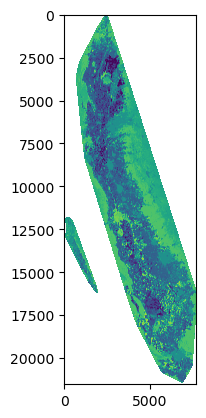

<Axes: >

In [8]:
# map clipped raster of the areas
from rasterio.plot import show
show(src_mask, cmap = 'viridis')

Each pixel in the raster image has a value corresponding to a classified crop or land use. The key for the legend is available at https://www.nass.usda.gov/Research_and_Science/Cropland/docs/CDL_codes_names_colors.xlsx. We will count the number of pixels for each of the LULC codes.

In [9]:
# count number of cells for each pixel value

count = np.unique(src_mask, return_counts=True)
df = pd.DataFrame(count).transpose()

df.rename(columns={0: 'Codes', 1: 'count'}, inplace=True)
df = df[df['Codes'] != '--']

Preview the table containing the code value and the corresponding number of pixels for the area of interest.

In [10]:
# Preview the table with codes and counts
df.head(10)

,Codes,count
0,1,661126
1,2,672937
2,3,1221853
3,4,29571
4,6,175351
5,12,16081
6,13,349
7,14,3
8,21,193581
9,22,12615


In [11]:
# read codes and legend of pixel values. Merge with pixel counts by codes and calculate area in ha
# the codes table identifies if it is or not a crop. The image has a resolution of 30x30 metres

codes = pd.read_csv('../external_data/CroplandCROS/CDL_code_names_colors.csv')
df = pd.merge(df, codes[['Codes', 'Class_Names', 'Scientific_name', 'EPPO_code', 'IsCrop']], \
              left_on='Codes', right_on='Codes')
df['areaHa'] = df['count']*900/10**4

In [12]:
# total area, calculation based in the number of pixels.
df['areaHa'].sum()

6632075.07

The total area of the area of interest is more than 6.6 million hectares. This includes crop and non-crop areas.

In [13]:
# count the number of codes that correspond to crops
len(df[(df['IsCrop']==1)])

63

In [14]:
# sum the area tha correspond to crops
(df['areaHa'][(df['IsCrop']==1)]).sum()

2724242.94

Based on the classification of the CroplandCROS, there are 63 crops in the area of interest. That covers a total area of more than 2.7 million hectares.

In [15]:
#save dataframe with crop data for later use
df.to_csv('../process_data/crop_data.csv')

The table with pixel classes was completed with additional data to be used latter in the workflow:<br>
- scientific name of the crop, for classes that correspond to crops
- code of the crop in the EPPO database
- when more than a crop exists for a pixel, the code of the crop growing in the nesting period of birds (April to June)
- the following classifiers
    - IsCrop: boolean to indicate if the class is a crop identified in the EPPO database
    - IsCropOther: boolean to indicate if the class is a crop identified in the EPPO database , or other crops not possible to identify
    - IsWoodland: boolean to indicate if the class correspond to permanent land cover (permanent crops, shrubs or trees)
    - IsFeedingArea: booleand to indicate if the class can be used by birds as feeding areas. Includes crops and woodlands
    - IsTempCrop: boolean to indicate if the class is a temporary crop
    - IsPermCrop: boolean to indicate if the class is a permanent crop

In [16]:
df.head(20).sort_values('Class_Names', ascending=True)
df

,Codes,count,Class_Names,Scientific_name,EPPO_code,IsCrop,areaHa
0,1,661126,Corn,Zea mays,ZEAMX,1,59501.34
1,2,672937,Cotton,Gossypium spp.,1GOSG,1,60564.33
2,3,1221853,Rice,Oryza sativa,ORYSA,1,109966.77
3,4,29571,Sorghum,Sorghum bicolor,SORVU,1,2661.39
4,6,175351,Sunflower,Helianthus annuus,HELAN,1,15781.59
...,...,...,...,...,...,...,...
82,229,9646,Pumpkins,Cucurbita pepo,CUUPE,1,868.14
83,236,39438,Dbl Crop WinWht/Sorghum,NaN,"SORVU,TRZAX",1,3549.42
84,237,5392,Dbl Crop Barley/Corn,NaN,"TRZAX,ZEAMX",1,485.28
85,238,2633,Dbl Crop WinWht/Cotton,NaN,"TRZAX,1GOSG",1,236.97


Create a graph with the crops that have the largest areas in the area of interest. Only crops having more than 50000 pixels in the area (4500 ha) are represented.

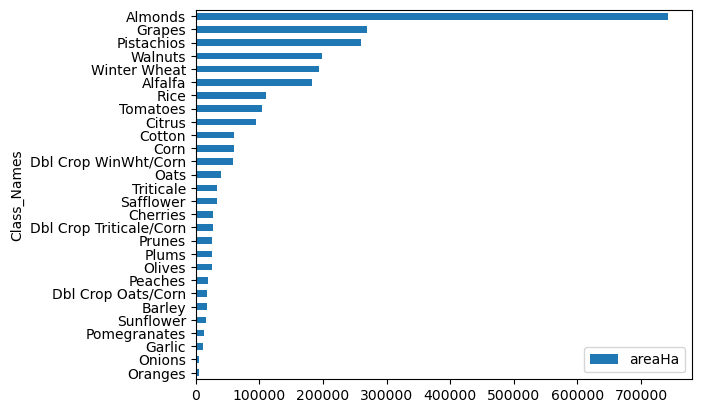

In [17]:
# plot area for each crop, for the largest crops (more than 50000 pixels)
ax = df[(df['IsCrop']==1) & (df['count'] > 50000)].sort_values('count').plot.barh(x = 'Class_Names', y = 'areaHa')